In [1]:
# Install required packages (if needed)
# !pip3 install pandas numpy matplotlib seaborn scikit-learn tqdm requests -q

# Ollama API setup and imports
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json
import time
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, precision_score, recall_score, confusion_matrix, classification_report
import numpy as np
from datetime import datetime
import re

print("✓ Libraries imported successfully")
print("✓ Ollama will be used for LLM inference (local)")

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

# Ollama API configuration
OLLAMA_API_URL = "http://localhost:11434/api/generate"

✓ Libraries imported successfully
✓ Ollama will be used for LLM inference (local)


## 1. Load Dataset

In [2]:
# Load the 100% agreement dataset (highest quality)
data_path = "../../DatasetAnalysis_FinancialPhraseBank/FinancialPhraseBank-v1.0/Sentences_AllAgree.txt"

sentences = []
risks = []

with open(data_path, "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        line = line.strip()
        if "@" in line:
            parts = line.rsplit("@", 1)
            if len(parts) == 2:
                sentences.append(parts[0])
                risks.append(parts[1])

df = pd.DataFrame({"sentence": sentences, "true_risk": risks})

print(f"Dataset loaded: {len(df)} sentences")
print(f"\nRisk distribution:")
print(df["true_risk"].value_counts())

# Display sample
print("\n" + "=" * 80)
print("Sample sentences:")
print("=" * 80)
display(df.sample(5, random_state=42))

Dataset loaded: 2264 sentences

Risk distribution:
true_risk
neutral     1391
positive     570
negative     303
Name: count, dtype: int64

Sample sentences:


,sentence,true_risk
1755,The contract value amounts to EUR 2.4 million .,neutral
1281,Kemira shares closed at ( x20ac ) 16.66 ( $ 2...,neutral
350,The company slipped to an operating loss of EU...,negative
420,According to Atria 's President and CEO Matti ...,positive
56,"In 2009 , Fiskars ' cash flow from operating a...",positive


## 2. Tree-of-Thought Prompt Design

**Multi-Path Reasoning**:
- Path 1: Consider "positive" hypothesis
- Path 2: Consider "negative" hypothesis  
- Path 3: Consider "neutral" hypothesis
- Evaluation: Score each path's evidence strength
- Selection: Choose the most supported hypothesis

In [3]:
def create_tot_prompt(sentence):
    """
    Creates a Tree-of-Thought prompt with multi-path exploration.
    """
    prompt = f"""You are a financial risk assessment expert. 

Financial Statement:
"{sentence}"

Task: Evaluate the risk of the following statement from an investor's perspective.

---
PATH 1: Hypothesis = POSITIVE
Opportunity signals that reduce investment risk, aligning with scenarios like 
- revenue growth
- profit increase
- market expansion
- strong performance

PATH 2: Hypothesis = NEGATIVE
Threat signals that increase investment risk, aligning with scenarios like
- losses
- declining sales
- operational challenges
- market difficulties

PATH 3: Hypothesis = NEUTRAL
Informational content with no or risk implications, routine announcements, balanced statements.

---
FINAL DECISION:
Based on evaluating all three paths, select the hypothesis with the strongest evidence.

Provide your final answer in this exact JSON format:
{{
    "risk": "positive/negative/neutral",
    "confidence": 0.0-1.0,
    "rationale": "Explanation of why this hypothesis was selected over the others"
    
}}
"""
    return prompt


# Test prompt
test_sentence = (
    "The company reported mixed results with revenue up 10% but margins declining."
)
print("=" * 80)
print("TREE-OF-THOUGHT PROMPT EXAMPLE")
print("=" * 80)
print(create_tot_prompt(test_sentence))

TREE-OF-THOUGHT PROMPT EXAMPLE
You are a financial risk assessment expert. 

Financial Statement:
"The company reported mixed results with revenue up 10% but margins declining."

Task: Evaluate the risk of the following statement from an investor's perspective.

---
PATH 1: Hypothesis = POSITIVE
Opportunity signals that reduce investment risk, aligning with scenarios like 
- revenue growth
- profit increase
- market expansion
- strong performance

PATH 2: Hypothesis = NEGATIVE
Threat signals that increase investment risk, aligning with scenarios like
- losses
- declining sales
- operational challenges
- market difficulties

PATH 3: Hypothesis = NEUTRAL
Informational content with no or risk implications, routine announcements, balanced statements.

---
FINAL DECISION:
Based on evaluating all three paths, select the hypothesis with the strongest evidence.

Provide your final answer in this exact JSON format:
{
    "risk": "positive/negative/neutral",
    "confidence": 0.0-1.0,
    "ratio

## 3. Model Inference Functions

In [4]:
def call_ollama(prompt, model_name, temperature=0.0):
    """Call Ollama API for LLM inference"""
    max_retries = 3
    last_error = None
    
    for attempt in range(max_retries):
        try:
            response = requests.post(
                OLLAMA_API_URL,
                json={
                    "model": model_name,
                    "prompt": prompt,
                    "stream": False,
                    "temperature": temperature,
                },
                timeout=150,
            )
            
            if response.status_code == 200:
                result = response.json()
                return result.get("response", "")
            else:
                last_error = f"HTTP {response.status_code}"
                
        except Exception as e:
            last_error = str(e)
            if attempt < max_retries - 1:
                time.sleep(2 ** attempt)
                continue
            return None
    
    return None


import json
import re

def parse_response(response_text):
    
    if not response_text or not isinstance(response_text, str):
        return {"risk": "error", "confidence": 0, "rationale": "No response"}

    # 1. CLEANING: Remove <think> tags (common in DeepSeek-R1)
    clean_text = re.sub(r'<think>.*?</think>', '', response_text, flags=re.DOTALL).strip()

    try:
        # 2. EXTRACTION: Find the JSON block
        # Looks for the LAST curly brace pair in case the model explains itself first
        json_match = re.findall(r'(\{.*\})', clean_text, re.DOTALL)
        
        if json_match:
            json_str = json_match[-1].strip()
            
            # FIX: Remove trailing commas that break json.loads (e.g., {"a": 1,})
            json_str = re.sub(r',\s*([\]}])', r'\1', json_str)
            
            result = json.loads(json_str)
            
            # Ensure we are dealing with a dictionary
            if isinstance(result, dict):
                # Handle nested "final_decision" structure if the LLM adds it
                if "final_decision" in result and isinstance(result["final_decision"], dict):
                    decision = result["final_decision"]
                else:
                    decision = result
                
                # Standardize keys: Look for "risk" or "sentiment"
                prediction = decision.get("risk") or decision.get("sentiment")
                
                if prediction:
                    return {
                        "risk": str(prediction).lower().strip(),
                        "confidence": float(decision.get("confidence", 0.5)),
                        "rationale": decision.get("rationale", "Parsed successfully")
                    }

        if clean_text.lower() in ["positive", "negative", "neutral"]:
            return {"risk": clean_text.lower(), "confidence": 0.5, "rationale": "Raw string match"}

    except Exception as e:
        # Fall through to keyword search
        pass

    res_low = clean_text.lower()
    search_zone = res_low.split("final decision")[-1] if "final decision" in res_low else res_low
    
    for label in ["positive", "negative", "neutral"]:
        if label in search_zone:
            return {
                "risk": label, 
                "confidence": 0.5, 
                "rationale": "Keyword fallback (Search zone)"
            }

    return {"risk": "error", "confidence": 0, "rationale": "Parse failed"}

print("✓ Inference functions defined")

✓ Inference functions defined


## 4. Run Experiments

In [5]:
# Run on sample dataset for faster iteration and debugging
test_df = df.head(200).copy()

def run_tot_experiment(test_df, model_name, exp_id):
    print(f"Running {exp_id}: {model_name} (ToT)...")
    results = []
    
    # Ensure dataframe has the correct risk column name
    true_col = "true_risk" if "true_risk" in test_df.columns else "true_sentiment"

    for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc=f"{exp_id} Progress"):
        prompt = create_tot_prompt(row["sentence"])
        response = call_ollama(prompt, model_name)
        
        if response:
            parsed = parse_response(response)
            results.append({
                "sentence": row["sentence"],
                "true_risk": row[true_col],
                "predicted_risk": parsed.get("risk", "error") if parsed else "error",
                "confidence": parsed.get("confidence", 0) if parsed else 0,
                "rationale": parsed.get("rationale", "Parse error") if parsed else "Parse error"
            })
        time.sleep(0.1)
    return pd.DataFrame(results)

In [6]:
# Execution of R10
r10_df = run_tot_experiment(test_df, "llama3.1:8b", "R10")

Running R10: llama3.1:8b (ToT)...


R10 Progress: 100%|██████████| 200/200 [56:42<00:00, 17.01s/it] 


In [27]:
print("\nR10 Sample Results:")
print("\nTrue Risk Counts:")
print(r10_df['true_risk'].value_counts())
print("\nPredicted Risk Counts:")
print(r10_df['predicted_risk'].value_counts())


R10 Sample Results:

True Risk Counts:
true_risk
positive    195
neutral       5
Name: count, dtype: int64

Predicted Risk Counts:
predicted_risk
positive                     150
negative                      45
neutral                        4
positive/negative/neutral      1
Name: count, dtype: int64


In [28]:
#update r10, df value where predicted risk is positive/negative/neutral to match neutral
r10_df['predicted_risk'] = r10_df['predicted_risk'].apply(lambda x: 'neutral' if x in ['positive/negative/neutral'] else x)
print("\nPredicted Risk Counts:")
print(r10_df['predicted_risk'].value_counts())


Predicted Risk Counts:
predicted_risk
positive    150
negative     45
neutral       5
Name: count, dtype: int64


In [8]:
#Execution of R11
r11_df = run_tot_experiment(test_df, "qwen3:8b", "R11")

Running R11: qwen3:8b (ToT)...


R11 Progress: 100%|██████████| 200/200 [2:23:15<00:00, 42.98s/it]  


In [29]:
print("\nR11 Sample Results:")
print("\nTrue Risk Counts:")
print(r11_df['true_risk'].value_counts())
print("\nPredicted Risk Counts:")
print(r11_df['predicted_risk'].value_counts())


R11 Sample Results:

True Risk Counts:
true_risk
positive    195
neutral       5
Name: count, dtype: int64

Predicted Risk Counts:
predicted_risk
positive    193
neutral       7
Name: count, dtype: int64


In [10]:
# Execution of R12
r12_df = run_tot_experiment(test_df, "deepseek-r1:8b", "R12")

Running R12: deepseek-r1:8b (ToT)...


R12 Progress: 100%|██████████| 200/200 [2:44:44<00:00, 49.42s/it]  


In [30]:
print("\nR12 Sample Results:")
print("\nTrue Risk Counts:")
print(r12_df['true_risk'].value_counts())
print("\nPredicted Risk Counts:")
print(r12_df['predicted_risk'].value_counts())


R12 Sample Results:

True Risk Counts:
true_risk
positive    195
neutral       5
Name: count, dtype: int64

Predicted Risk Counts:
predicted_risk
positive    192
neutral       7
negative      1
Name: count, dtype: int64


## 5. Calculate Metrics

In [33]:
# Calculate metrics for all experiments
def calculate_metrics(df, exp_name):
    """Calculate all evaluation metrics"""
    if df.empty or "predicted_risk" not in df.columns:
        print(f"⚠️ Warning: {exp_name} has no valid predictions!")
        return (
            {
                "Experiment": exp_name,
                "Total Samples": 0,
                "Valid Predictions": 0,
                "Accuracy": 0,
                "Macro-F1": 0,
                "Weighted-F1": 0,
                "Macro-Precision": 0,
                "Macro-Recall": 0,
                "MCC": 0,
                "Positive_Precision": 0,
                "Positive_Recall": 0,
                "Positive_F1": 0,
                "Negative_Precision": 0,
                "Negative_Recall": 0,
                "Negative_F1": 0,
                "Neutral_Precision": 0,
                "Neutral_Recall": 0,
                "Neutral_F1": 0,
            },
            np.zeros((3, 3)),
            pd.DataFrame(),
        )
    
    valid_df = df[
        df["predicted_risk"].isin(["positive", "negative", "neutral"])
    ].copy()
    if valid_df.empty:
        print(f"⚠️ Warning: {exp_name} has no valid predictions after filtering!")
        return (
            {
                "Experiment": exp_name,
                "Total Samples": len(df),
                "Valid Predictions": 0,
                "Accuracy": 0,
                "Macro-F1": 0,
                "Weighted-F1": 0,
                "Macro-Precision": 0,
                "MCC": 0,
                "Positive_Precision": 0,
                "Positive_Recall": 0,
                "Positive_F1": 0,
                "Negative_Precision": 0,
                "Negative_Recall": 0,
                "Negative_F1": 0,
                "Neutral_Precision": 0,
                "Neutral_Recall": 0,
                "Neutral_F1": 0,
            },
            np.zeros((3, 3)),
            pd.DataFrame(),
        )
    y_true = valid_df["true_risk"]
    y_pred = valid_df["predicted_risk"]
    
    metrics = {
        "Experiment": exp_name,
        "Total Samples": len(df),
        "Valid Predictions": len(valid_df),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Macro-F1": f1_score(y_true, y_pred, average="macro"),
        "Weighted-F1": f1_score(y_true, y_pred, average="weighted"),
        "Macro-Precision": precision_score(y_true, y_pred, average="macro"),
        "Macro-Recall": recall_score(y_true, y_pred, average="macro"),
        "MCC": matthews_corrcoef(y_true, y_pred),
    }
    
    labels = ["positive", "negative", "neutral"]
    precision_per_class = precision_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )
    recall_per_class = recall_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )
    f1_per_class = f1_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )

    for i, label in enumerate(labels):
        metrics[f"{label.capitalize()}_Precision"] = precision_per_class[i]
        metrics[f"{label.capitalize()}_Recall"] = recall_per_class[i]
        metrics[f"{label.capitalize()}_F1"] = f1_per_class[i]

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    return metrics, cm, valid_df


# Calculate metrics for all experiments
r10_metrics, r10_cm, r10_valid = calculate_metrics(r10_df, "R10: Llama3.1:8b (ToT)")
r11_metrics, r11_cm, r11_valid = calculate_metrics(r11_df, "R11: Qwen3:8b (ToT)")
r12_metrics, r12_cm, r12_valid = calculate_metrics(r12_df, "R12: DeepSeek-R1:8b (ToT)")

metrics_df = pd.DataFrame([r10_metrics, r11_metrics, r12_metrics])
print("\n" + "=" * 80)
print("CHAIN-OF-THOUGHT PERFORMANCE COMPARISON")
print("=" * 80)
display(
    metrics_df[
        ["Experiment", "Accuracy", "Macro-F1", "Macro-Precision", "Macro-Recall"]
    ].round(4)
)


CHAIN-OF-THOUGHT PERFORMANCE COMPARISON


/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Experiment,Accuracy,Macro-F1,Macro-Precision,Macro-Recall
0,R10: Llama3.1:8b (ToT),0.740,0.2860,0.3289,0.2530
1,R11: Qwen3:8b (ToT),0.980,0.8282,0.7831,0.8923
2,R12: DeepSeek-R1:8b (ToT),0.975,0.5512,0.5221,0.5932


## 6. Visualize Results

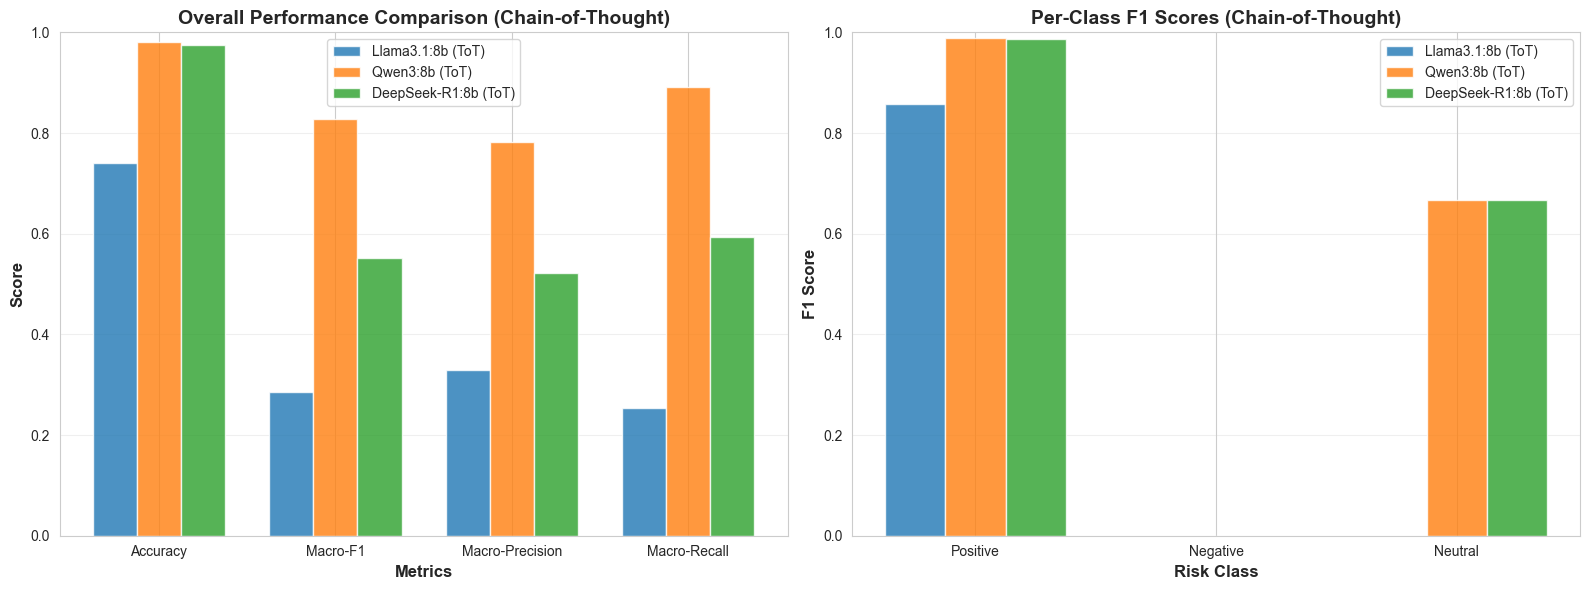

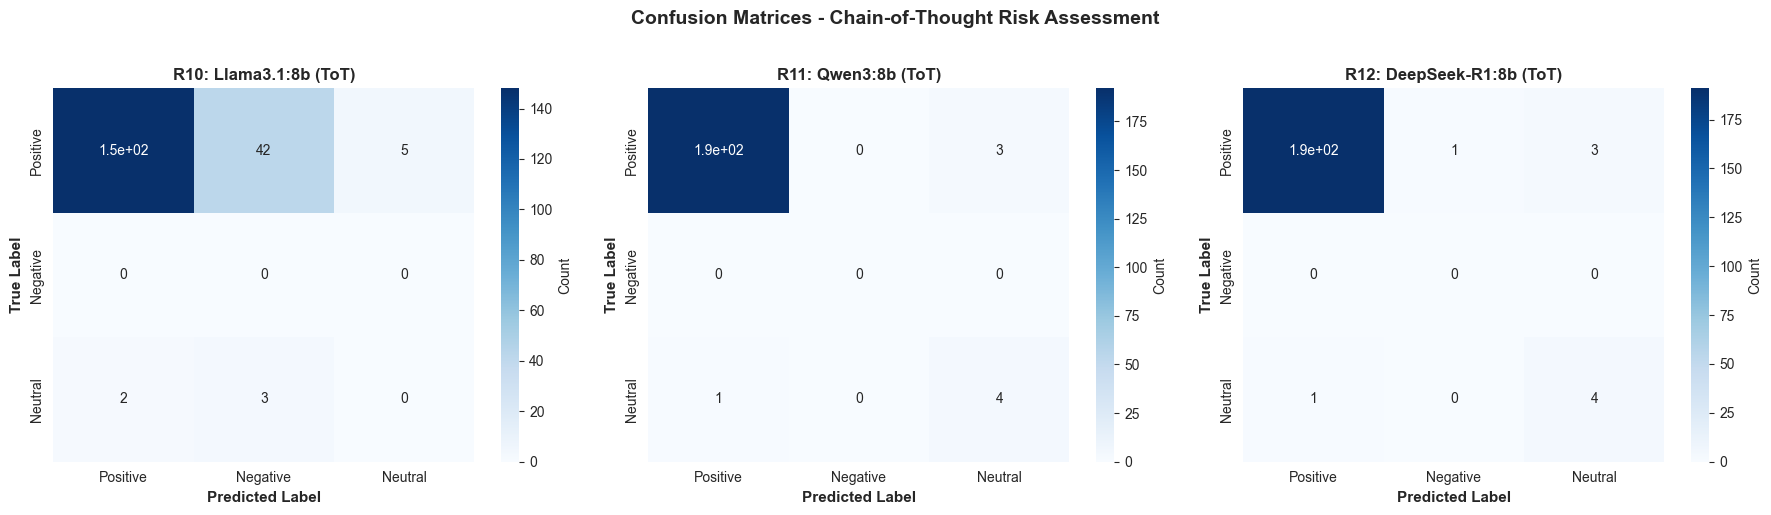

In [34]:
# Performance comparison bar chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Overall metrics
metrics_to_plot = ["Accuracy", "Macro-F1", "Macro-Precision", "Macro-Recall"]
x = np.arange(len(metrics_to_plot))
width = 0.25

for i, (metrics, label) in enumerate(
    [
        (r10_metrics, "Llama3.1:8b (ToT)"),
        (r11_metrics, "Qwen3:8b (ToT)"),
        (r12_metrics, "DeepSeek-R1:8b (ToT)"),
    ]
):
    values = [np.nan_to_num(metrics.get(m, 0.0)) for m in metrics_to_plot]
    axes[0].bar(x + i * width, values, width, label=label, alpha=0.8)

axes[0].set_xlabel("Metrics", fontsize=12, weight="bold")
axes[0].set_ylabel("Score", fontsize=12, weight="bold")
axes[0].set_title(
    "Overall Performance Comparison (Chain-of-Thought)", fontsize=14, weight="bold"
)
axes[0].set_xticks(x + width)
axes[0].set_xticklabels(metrics_to_plot)
axes[0].legend()
axes[0].set_ylim([0, 1])
axes[0].grid(axis="y", alpha=0.3)

# Per-class F1 scores
classes = ["Positive", "Negative", "Neutral"]
x2 = np.arange(len(classes))

for i, (metrics, label) in enumerate(
    [
        (r10_metrics, "Llama3.1:8b (ToT)"),
        (r11_metrics, "Qwen3:8b (ToT)"),
        (r12_metrics, "DeepSeek-R1:8b (ToT)"),
    ]
):
    values = [metrics[f"{c}_F1"] for c in classes]
    axes[1].bar(x2 + i * width, values, width, label=label, alpha=0.8)

axes[1].set_xlabel("Risk Class", fontsize=12, weight="bold")
axes[1].set_ylabel("F1 Score", fontsize=12, weight="bold")
axes[1].set_title("Per-Class F1 Scores (Chain-of-Thought)", fontsize=14, weight="bold")
axes[1].set_xticks(x2 + width)
axes[1].set_xticklabels(classes)
axes[1].legend()
axes[1].set_ylim([0, 1])
axes[1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("tot_performance_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
labels = ["Positive", "Negative", "Neutral"]

for idx, (cm, title) in enumerate(
    [
        (r10_cm, "R10: Llama3.1:8b (ToT)"),
        (r11_cm, "R11: Qwen3:8b (ToT)"),
        (r12_cm, "R12: DeepSeek-R1:8b (ToT)"),
    ]
):
    sns.heatmap(
        cm,
        annot=True,
        
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
        ax=axes[idx],
        cbar_kws={"label": "Count"},
    )
    axes[idx].set_title(title, fontsize=12, weight="bold")
    axes[idx].set_ylabel("True Label", fontsize=11, weight="bold")
    axes[idx].set_xlabel("Predicted Label", fontsize=11, weight="bold")

plt.suptitle(
    "Confusion Matrices - Chain-of-Thought Risk Assessment",
    fontsize=14,
    weight="bold",
    y=1.02,
)
plt.tight_layout()
plt.savefig("tot_confusion_matrices.png", dpi=300, bbox_inches="tight")
plt.show()

## 7. Save Results

In [35]:
# Save detailed results
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

r10_df.to_csv(f"r10_llama3.1_8b_ToT_{timestamp}.csv", index=False)
r11_df.to_csv(f"r11_qwen3_8b_ToT_{timestamp}.csv", index=False)
r12_df.to_csv(f"r12_deepseek_r1_8b_ToT_{timestamp}.csv", index=False)

# Save metrics summary
metrics_df.to_csv(f"tot_metrics_summary_{timestamp}.csv", index=False)

print(f"\n✓ Chain-of-Thought results saved with timestamp: {timestamp}")
print("\nFiles created:")
print(f"  - r10_llama3.1_8b_ToT_{timestamp}.csv")
print(f"  - r11_qwen3_8b_ToT_{timestamp}.csv")
print(f"  - r12_deepseek_r1_8b_ToT_{timestamp}.csv")
print(f"  - ToT_metrics_summary_{timestamp}.csv")
print(f"  - ToT_performance_comparison.png")
print(f"  - ToT_confusion_matrices.png")


✓ Chain-of-Thought results saved with timestamp: 20260216_170453

Files created:
  - r10_llama3.1_8b_ToT_20260216_170453.csv
  - r11_qwen3_8b_ToT_20260216_170453.csv
  - r12_deepseek_r1_8b_ToT_20260216_170453.csv
  - ToT_metrics_summary_20260216_170453.csv
  - ToT_performance_comparison.png
  - ToT_confusion_matrices.png


## 8. Error Analysis

In [36]:
# Error Analysis: Most Common Misclassifications
print("=" * 80)
print("ERROR ANALYSIS: CHAIN-OF-THOUGHT MISCLASSIFICATION PATTERNS")
print("=" * 80)

for df_result, exp_name in [
    (r10_valid, "R10: Llama3.1:8b"),
    (r11_valid, "R11: Qwen3:8b"),
    (r12_valid, "R12: DeepSeek-R1:8b"),
]:
    print(f"\n{exp_name}")
    print("-" * 80)

    # Identify errors
    errors = df_result[df_result["true_risk"] != df_result["predicted_risk"]]

    # Count error types
    error_types = (
        errors.groupby(["true_risk", "predicted_risk"])
        .size()
        .reset_index(name="count")
    )
    error_types = error_types.sort_values("count", ascending=False)

    print(
        f"\nTotal Errors: {len(errors)} / {len(df_result)} ({len(errors) / len(df_result) * 100:.2f}%)"
    )
    print("\nMost Common Error Types:")
    display(error_types.head(5))

    # Show examples of worst errors (high confidence, wrong prediction)
    if len(errors) > 0:
        worst_errors = errors.nlargest(3, "confidence")
        print(f"\nTop 3 High-Confidence Errors:")
        for idx, row in worst_errors.iterrows():
            print(
                f"\n  True: {row['true_risk']} | Predicted: {row['predicted_risk']} | Conf: {row['confidence']:.2f}"
            )
            print(f"  Sentence: {row['sentence'][:120]}...")
            print(f"  Rationale: {row['rationale']}")

# Class-wise Performance Comparison
print("\n" + "=" * 80)
print("CLASS-WISE PERFORMANCE BREAKDOWN")
print("=" * 80)

class_comparison = []
for metrics, model_name in [
    (r10_metrics, "Llama3.1:8b"),
    (r11_metrics, "Qwen3:8b"),
    (r12_metrics, "DeepSeek-R1:8b"),
]:
    for risk in ["Positive", "Negative", "Neutral"]:
        class_comparison.append(
            {
                "Model": model_name,
                "Class": risk,
                "Precision": metrics[f"{risk}_Precision"],
                "Recall": metrics[f"{risk}_Recall"],
                "F1-Score": metrics[f"{risk}_F1"],
            }
        )

class_df = pd.DataFrame(class_comparison)

# Pivot for better visualization
for metric in ["Precision", "Recall", "F1-Score"]:
    print(f"\n{metric} by Class:")
    pivot = class_df.pivot(index="Class", columns="Model", values=metric)
    display(pivot.round(4))

print("\n" + "=" * 80)
print("COMPREHENSIVE METRICS TABLE")
print("=" * 80)
display(metrics_df.round(4))

ERROR ANALYSIS: CHAIN-OF-THOUGHT MISCLASSIFICATION PATTERNS

R10: Llama3.1:8b
--------------------------------------------------------------------------------

Total Errors: 52 / 200 (26.00%)

Most Common Error Types:


,true_risk,predicted_risk,count
2,positive,negative,42
3,positive,neutral,5
0,neutral,negative,3
1,neutral,positive,2



Top 3 High-Confidence Errors:

  True: positive | Predicted: neutral | Conf: 0.90
  Sentence: In January-September 2010 , Fiskars ' net profit went up by 14 % year-on-year to EUR 65.4 million and net sales to EUR 5...
  Rationale: The information provided indicates a positive trend in Fiskars' performance, with a 14% year-on-year increase in net profit and a corresponding growth in net sales. This suggests that the company is experiencing strong revenue growth and profitability, which are opportunity signals that reduce investment risk.

  True: positive | Predicted: neutral | Conf: 0.90
  Sentence: However , sales returned to growth in April-June 2010 , CEO Pekka Eloholma said ....
  Rationale: The statement attributes a positive trend (sales growth) to a specific period and maintains a neutral tone, without any warning signs of negative developments.

  True: positive | Predicted: negative | Conf: 0.80
  Sentence: For the last quarter of 2010 , Componenta 's net sales doubled to EUR

,true_risk,predicted_risk,count
1,positive,neutral,3
0,neutral,positive,1



Top 3 High-Confidence Errors:

  True: positive | Predicted: neutral | Conf: 0.90
  Sentence: Shares of Standard Chartered ( STAN ) rose 1.2 % in the FTSE 100 , while Royal Bank of Scotland ( RBS ) shares rose 2 % ...
  Rationale: The statement reports stock price increases but provides no contextual information about underlying factors (e.g., revenue growth, market expansion) that would align with a positive hypothesis. Similarly, there is no mention of threats or risks (e.g., losses, operational challenges) to support a negative hypothesis. The information is purely observational (price movements) without explicit risk implications, aligning with the neutral hypothesis as routine market activity rather than a signal for investment risk.

  True: positive | Predicted: neutral | Conf: 0.85
  Sentence: A Helsinki : ELIiV today reported EPS of EUR1 .13 for 2009 , an increase over EPS of EUR1 .12 in 2008 ....
  Rationale: The EPS increase is minimal (0.01 EUR) and does not strongly indic

,true_risk,predicted_risk,count
2,positive,neutral,3
0,neutral,positive,1
1,positive,negative,1



Top 3 High-Confidence Errors:

  True: positive | Predicted: neutral | Conf: 0.95
  Sentence: Net sales grew in the period to  x20ac 402 million $ 585US million from  x20ac 401 million in 2006 ....
  Rationale: The statement indicates a very modest increase in net sales (from 401 million to 402 million USD, representing a negligible growth of approximately 0.024%). While this is a positive numerical change, the minimal growth is insufficient to signal significant positive momentum or strong performance from an investment perspective. There are no indications of substantial profit increase, market expansion, or strong performance that would warrant a positive risk assessment. It does not indicate negative factors either. However, the lack of substantial growth means it does not provide meaningful evidence for a positive investment thesis either. Therefore, the statement is primarily informational with no significant risk implications, aligning with the neutral hypothesis.

  True: posi

Model,DeepSeek-R1:8b,Llama3.1:8b,Qwen3:8b
Class,,,
Negative,0.0000,0.0000,0.0000
Neutral,0.5714,0.0000,0.5714
Positive,0.9948,0.9867,0.9948



Recall by Class:


Model,DeepSeek-R1:8b,Llama3.1:8b,Qwen3:8b
Class,,,
Negative,0.0000,0.000,0.0000
Neutral,0.8000,0.000,0.8000
Positive,0.9795,0.759,0.9846



F1-Score by Class:


Model,DeepSeek-R1:8b,Llama3.1:8b,Qwen3:8b
Class,,,
Negative,0.0000,0.000,0.0000
Neutral,0.6667,0.000,0.6667
Positive,0.9871,0.858,0.9897



COMPREHENSIVE METRICS TABLE


,Experiment,Total Samples,Valid Predictions,Accuracy,Macro-F1,Weighted-F1,Macro-Precision,Macro-Recall,MCC,Positive_Precision,Positive_Recall,Positive_F1,Negative_Precision,Negative_Recall,Negative_F1,Neutral_Precision,Neutral_Recall,Neutral_F1
0,R10: Llama3.1:8b (ToT),200,200,0.740,0.2860,0.8365,0.3289,0.2530,0.0592,0.9867,0.7590,0.8580,0.0,0.0,0.0,0.0000,0.0,0.0000
1,R11: Qwen3:8b (ToT),200,200,0.980,0.8282,0.9816,0.7831,0.8923,0.6665,0.9948,0.9846,0.9897,0.0,0.0,0.0,0.5714,0.8,0.6667
2,R12: DeepSeek-R1:8b (ToT),200,200,0.975,0.5512,0.9791,0.5221,0.5932,0.6217,0.9948,0.9795,0.9871,0.0,0.0,0.0,0.5714,0.8,0.6667


## 10. Confidence Calibration Analysis

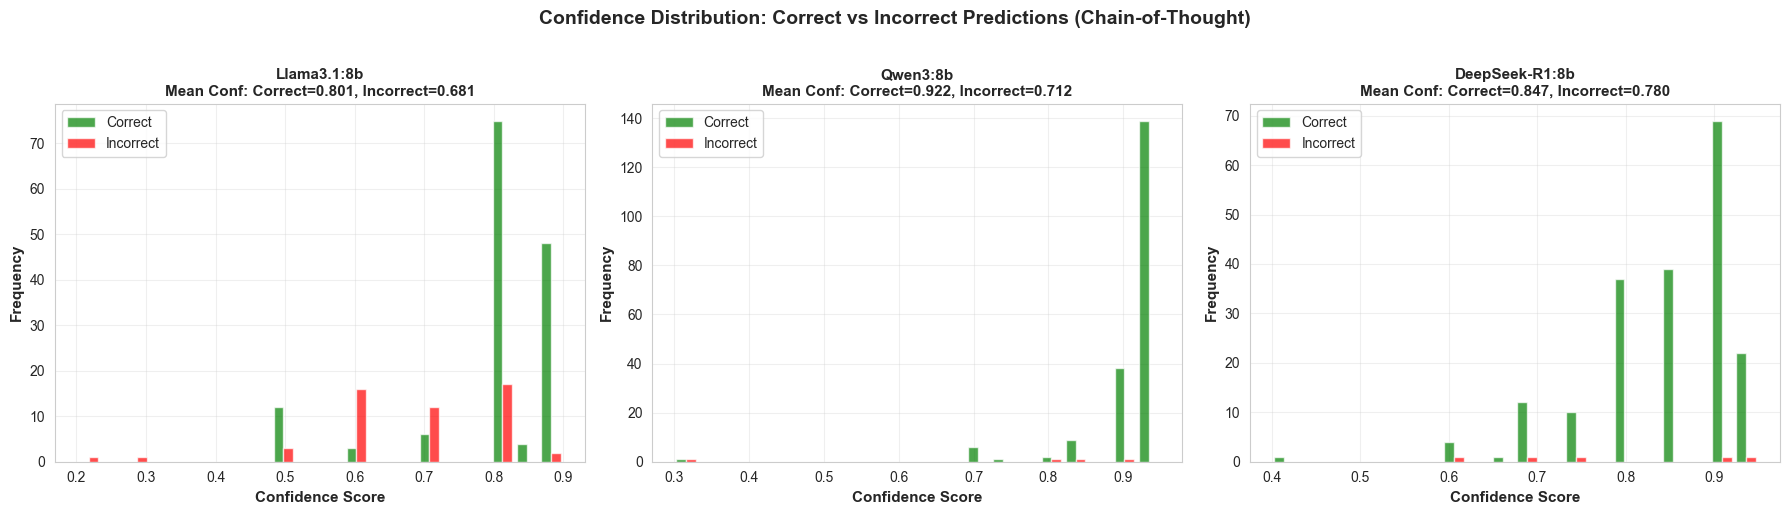


CONFIDENCE CALIBRATION ANALYSIS

R10: Llama3.1:8b:
  Average Confidence (Correct): 0.8014
  Average Confidence (Incorrect): 0.6808
  Calibration Gap: 0.1206
  Total Correct: 148 / 200

  Confidence by Predicted Class:
    Positive: 0.7993 (n=150)
    Negative: 0.6711 (n=45)
    Neutral: 0.7800 (n=5)

R11: Qwen3:8b:
  Average Confidence (Correct): 0.9222
  Average Confidence (Incorrect): 0.7125
  Calibration Gap: 0.2097
  Total Correct: 196 / 200

  Confidence by Predicted Class:
    Positive: 0.9236 (n=193)
    Neutral: 0.7643 (n=7)

R12: DeepSeek-R1:8b:
  Average Confidence (Correct): 0.8467
  Average Confidence (Incorrect): 0.7800
  Calibration Gap: 0.0667
  Total Correct: 195 / 200

  Confidence by Predicted Class:
    Positive: 0.8448 (n=192)
    Negative: 0.7000 (n=1)
    Neutral: 0.8714 (n=7)


In [37]:
# Confidence Analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (df_result, title) in enumerate(
    [(r10_valid, "Llama3.1:8b"), (r11_valid, "Qwen3:8b"), (r12_valid, "DeepSeek-R1:8b")]
):
    df_result["correct"] = (
        df_result["true_risk"] == df_result["predicted_risk"]
    )

    correct_conf = df_result[df_result["correct"]]["confidence"]
    incorrect_conf = df_result[~df_result["correct"]]["confidence"]

    axes[idx].hist(
        [correct_conf, incorrect_conf],
        bins=20,
        label=["Correct", "Incorrect"],
        alpha=0.7,
        color=["green", "red"],
    )
    axes[idx].set_xlabel("Confidence Score", fontsize=11, weight="bold")
    axes[idx].set_ylabel("Frequency", fontsize=11, weight="bold")
    axes[idx].set_title(
        f"{title}\nMean Conf: Correct={correct_conf.mean():.3f}, Incorrect={incorrect_conf.mean():.3f}",
        fontsize=11,
        weight="bold",
    )
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.suptitle(
    "Confidence Distribution: Correct vs Incorrect Predictions (Chain-of-Thought)",
    fontsize=14,
    weight="bold",
    y=1.02,
)
plt.tight_layout()
plt.savefig("tot_confidence_analysis.png", dpi=300, bbox_inches="tight")
plt.show()

print("\n" + "=" * 80)
print("CONFIDENCE CALIBRATION ANALYSIS")
print("=" * 80)
for df_result, exp_name in [
    (r10_valid, "R10: Llama3.1:8b"),
    (r11_valid, "R11: Qwen3:8b"),
    (r12_valid, "R12: DeepSeek-R1:8b"),
]:
    df_result["correct"] = (
        df_result["true_risk"] == df_result["predicted_risk"]
    )

    avg_conf_correct = df_result[df_result["correct"]]["confidence"].mean()
    avg_conf_incorrect = df_result[~df_result["correct"]]["confidence"].mean()
    calibration_gap = avg_conf_correct - avg_conf_incorrect

    print(f"\n{exp_name}:")
    print(f"  Average Confidence (Correct): {avg_conf_correct:.4f}")
    print(f"  Average Confidence (Incorrect): {avg_conf_incorrect:.4f}")
    print(f"  Calibration Gap: {calibration_gap:.4f}")
    print(f"  Total Correct: {df_result['correct'].sum()} / {len(df_result)}")

    # Confidence by risk class
    print(f"\n  Confidence by Predicted Class:")
    for risk in ["positive", "negative", "neutral"]:
        class_df = df_result[df_result["predicted_risk"] == risk]
        if len(class_df) > 0:
            print(
                f"    {risk.capitalize()}: {class_df['confidence'].mean():.4f} (n={len(class_df)})"
            )

## 11. Classification Reports with Per-Class Metrics

In [38]:
# Detailed Classification Reports
print("\n" + "=" * 80)
print("DETAILED CLASSIFICATION REPORTS")
print("=" * 80)

for df_result, exp_name in [
    (r10_valid, "R10: Llama3.1:8b"),
    (r11_valid, "R11: Qwen3:8b"),
    (r12_valid, "R12: DeepSeek-R1:8b"),
]:
    print("\n" + "=" * 80)
    print(f"{exp_name}")
    print("=" * 80)
    print(
        classification_report(
            df_result["true_risk"],
            df_result["predicted_risk"],
            labels=["positive", "negative", "neutral"],
            target_names=["Positive", "Negative", "Neutral"],
        )
    )

# Class-wise Metrics Summary Table
print("\n" + "=" * 80)
print("CLASS-WISE METRICS SUMMARY")
print("=" * 80)

summary_data = []
for metrics, model in [
    (r10_metrics, "Llama3.1:8b"),
    (r11_metrics, "Qwen3:8b"),
    (r12_metrics, "DeepSeek-R1:8b"),
]:
    summary_data.append(
        {
            "Model": model,
            "Pos_P": metrics["Positive_Precision"],
            "Pos_R": metrics["Positive_Recall"],
            "Pos_F1": metrics["Positive_F1"],
            "Neg_P": metrics["Negative_Precision"],
            "Neg_R": metrics["Negative_Recall"],
            "Neg_F1": metrics["Negative_F1"],
            "Neu_P": metrics["Neutral_Precision"],
            "Neu_R": metrics["Neutral_Recall"],
            "Neu_F1": metrics["Neutral_F1"],
        }
    )

summary_df = pd.DataFrame(summary_data)
print("\nPer-Class Metrics (P=Precision, R=Recall, F1=F1-Score):")
display(summary_df.round(4))


DETAILED CLASSIFICATION REPORTS

R10: Llama3.1:8b
              precision    recall  f1-score   support

    Positive       0.99      0.76      0.86       195
    Negative       0.00      0.00      0.00         0
     Neutral       0.00      0.00      0.00         5

    accuracy                           0.74       200
   macro avg       0.33      0.25      0.29       200
weighted avg       0.96      0.74      0.84       200


R11: Qwen3:8b
              precision    recall  f1-score   support

    Positive       0.99      0.98      0.99       195
    Negative       0.00      0.00      0.00         0
     Neutral       0.57      0.80      0.67         5

    accuracy                           0.98       200
   macro avg       0.52      0.59      0.55       200
weighted avg       0.98      0.98      0.98       200


R12: DeepSeek-R1:8b
              precision    recall  f1-score   support

    Positive       0.99      0.98      0.99       195
    Negative       0.00      0.00      0.0

/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to

,Model,Pos_P,Pos_R,Pos_F1,Neg_P,Neg_R,Neg_F1,Neu_P,Neu_R,Neu_F1
0,Llama3.1:8b,0.9867,0.7590,0.8580,0.0,0.0,0.0,0.0000,0.0,0.0000
1,Qwen3:8b,0.9948,0.9846,0.9897,0.0,0.0,0.0,0.5714,0.8,0.6667
2,DeepSeek-R1:8b,0.9948,0.9795,0.9871,0.0,0.0,0.0,0.5714,0.8,0.6667


## 12. ToT vs CoT vs Few-Shot vs Zero-Shot Comparison

In [39]:
import glob
# Load previous approach metrics for comparison
try:
    # Find the most recent metrics files
    zero_shot_files = sorted(glob.glob("../Zero_Shot/zero_shot_metrics_summary_*.csv"))
    few_shot_files = sorted(glob.glob("../Few_Shot/few_shot_risk_metrics_summary_*.csv"))
    cot_files = sorted(glob.glob("../Chain_of_Thought/cot_metrics_summary_*.csv"))

    zero_shot_metrics = pd.read_csv(zero_shot_files[-1]) if zero_shot_files else None
    few_shot_metrics = pd.read_csv(few_shot_files[-1]) if few_shot_files else None
    cot_metrics = pd.read_csv(cot_files[-1]) if cot_files else None

    if zero_shot_metrics is not None:
        print(f"✓ Loaded Zero-Shot metrics from: {zero_shot_files[-1]}")
    if few_shot_metrics is not None:
        print(f"✓ Loaded Few-Shot metrics from: {few_shot_files[-1]}")
    if cot_metrics is not None:
        print(f"✓ Loaded CoT metrics from: {cot_files[-1]}")

except Exception as e:
    print(f"⚠️ Could not load comparison metrics: {e}")
    zero_shot_metrics = None
    few_shot_metrics = None
    cot_metrics = None

✓ Loaded Zero-Shot metrics from: ../Zero_Shot/zero_shot_metrics_summary_20260213_005016.csv
✓ Loaded Few-Shot metrics from: ../Few_Shot/few_shot_risk_metrics_summary_20260214_100938.csv
✓ Loaded CoT metrics from: ../Chain_of_Thought/cot_metrics_summary_20260215_000109.csv



CROSS-APPROACH COMPARISON: Zero-Shot vs Few-Shot vs CoT vs ToT


,Approach,Experiment,Total Samples,Valid Predictions,Accuracy,Macro-F1,Weighted-F1,Macro-Precision,Macro-Recall,MCC,Positive_Precision,Positive_Recall,Positive_F1,Negative_Precision,Negative_Recall,Negative_F1,Neutral_Precision,Neutral_Recall,Neutral_F1
0,Zero-Shot,R1: llama3.1:8b (Zero-Shot),200,200,0.960,0.4401,0.9707,0.6649,0.3932,0.3893,0.9948,0.9795,0.9871,0.0,0.0,0.0,1.0000,0.2,0.3333
1,Zero-Shot,R2: qwen3:8b (Zero-Shot),200,200,0.995,0.9432,0.9947,0.9974,0.9000,0.8921,0.9949,1.0000,0.9974,0.0,0.0,0.0,1.0000,0.8,0.8889
2,Zero-Shot,R3: deepseek-r1:8b (Zero-Shot),200,200,0.985,0.5974,0.9875,0.5983,0.5966,0.7236,0.9948,0.9897,0.9923,0.0,0.0,0.0,0.8000,0.8,0.8000
3,Few-Shot,R4: Llama3.1:8b (Few-Shot),200,200,0.925,0.4684,0.9477,0.4946,0.4462,0.2211,0.9839,0.9385,0.9606,0.0,0.0,0.0,0.5000,0.4,0.4444
4,Few-Shot,R5: Qwen3:8b (Few-Shot),200,200,0.990,0.8974,0.9900,0.8974,0.8974,0.7949,0.9949,0.9949,0.9949,0.0,0.0,0.0,0.8000,0.8,0.8000
5,Few-Shot,R6: DeepSeek-R1:8b (Few-Shot),200,200,0.960,0.4939,0.9697,0.4545,0.5880,0.5667,1.0000,0.9641,0.9817,0.0,0.0,0.0,0.3636,0.8,0.5000
6,Chain-of-Thought,R7: Llama3.1:8b (CoT),200,200,0.950,0.4375,0.9631,0.6632,0.3897,0.2890,0.9895,0.9692,0.9793,0.0,0.0,0.0,1.0000,0.2,0.3333
7,Chain-of-Thought,R8: Qwen3:8b (CoT),200,200,0.995,0.9432,0.9947,0.9974,0.9000,0.8921,0.9949,1.0000,0.9974,0.0,0.0,0.0,1.0000,0.8,0.8889
8,Chain-of-Thought,R9: DeepSeek-R1:8b (CoT),200,200,0.950,0.5000,0.9625,0.4524,0.6496,0.5625,1.0000,0.9487,0.9737,0.0,0.0,0.0,0.3571,1.0,0.5263
9,Tree-of-Thought,R10: Llama3.1:8b (ToT),200,200,0.740,0.2860,0.8365,0.3289,0.2530,0.0592,0.9867,0.7590,0.8580,0.0,0.0,0.0,0.0000,0.0,0.0000



✓ Full comparison table saved as: all_approaches_comparison_20260216_170453.csv

AVERAGE PERFORMANCE BY APPROACH


,Accuracy,Macro-F1,MCC
Approach,,,
Chain-of-Thought,0.9650,0.6269,0.5812
Few-Shot,0.9583,0.6199,0.5276
Tree-of-Thought,0.8983,0.5551,0.4491
Zero-Shot,0.9800,0.6602,0.6683


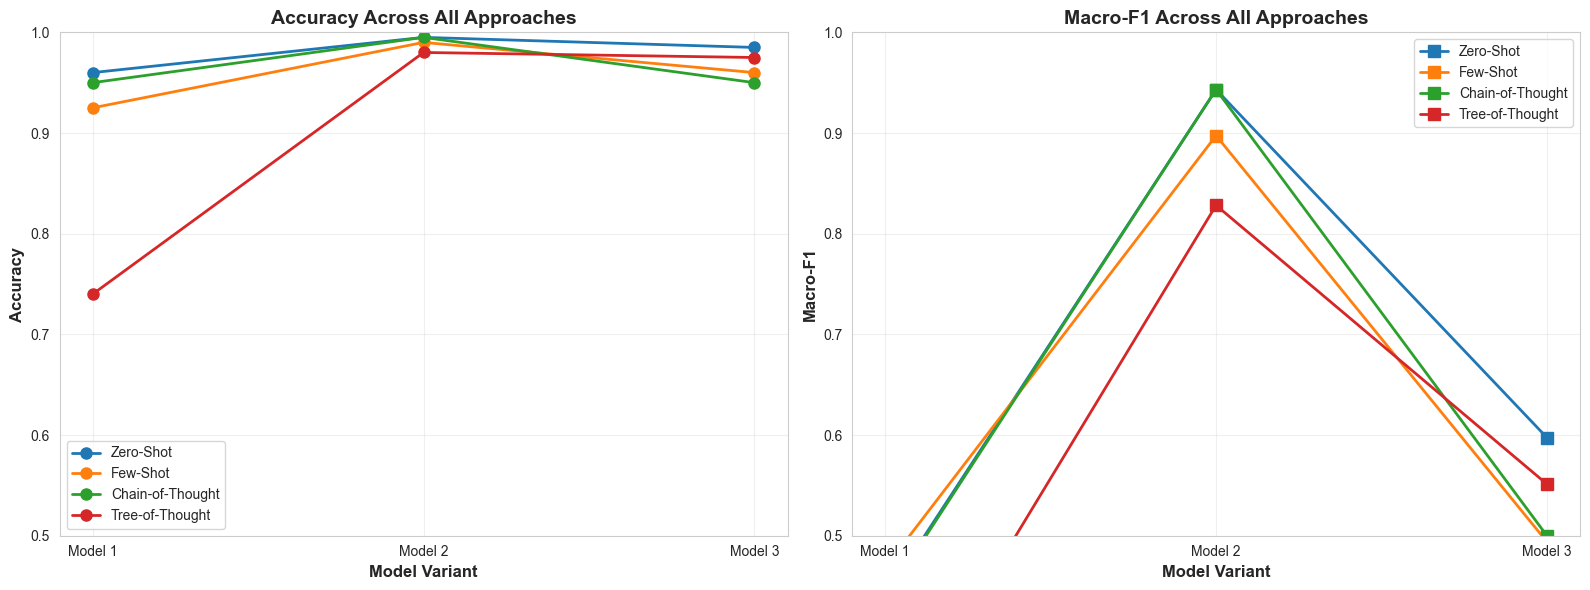

✓ Complete approach comparison visualization saved


In [45]:
# Compare all four approaches
if all(m is not None for m in [zero_shot_metrics, few_shot_metrics, cot_metrics]):
    all_approaches = pd.concat(
        [
            zero_shot_metrics.assign(Approach="Zero-Shot"),
            few_shot_metrics.assign(Approach="Few-Shot"),
            cot_metrics.assign(Approach="Chain-of-Thought"),
            metrics_df.assign(Approach="Tree-of-Thought"),
        ],
        ignore_index=True,
    )

    print("\n" + "=" * 80)
    print("CROSS-APPROACH COMPARISON: Zero-Shot vs Few-Shot vs CoT vs ToT")
    print("=" * 80)

    
    comparison_cols = ["Approach", "Experiment", "Accuracy", "Macro-F1", "MCC"]
    if all(col in all_approaches.columns for col in comparison_cols):
        display(all_approaches[['Approach', 'Experiment', 'Total Samples', 'Valid Predictions', 'Accuracy',
       'Macro-F1', 'Weighted-F1', 'Macro-Precision', 'Macro-Recall', 'MCC',
       'Positive_Precision', 'Positive_Recall', 'Positive_F1',
       'Negative_Precision', 'Negative_Recall', 'Negative_F1',
       'Neutral_Precision', 'Neutral_Recall', 'Neutral_F1']].round(4))
        #save to csv
        all_approaches.to_csv(f"all_approaches_comparison_{timestamp}.csv", index=False)
        print(f"\n✓ Full comparison table saved as: all_approaches_comparison_{timestamp}.csv")
    else:
        display(
            all_approaches[['Approach', 'Experiment', 'Total Samples', 'Valid Predictions', 'Accuracy',
       'Macro-F1', 'Weighted-F1', 'Macro-Precision', 'Macro-Recall', 'MCC',
       'Positive_Precision', 'Positive_Recall', 'Positive_F1',
       'Negative_Precision', 'Negative_Recall', 'Negative_F1',
       'Neutral_Precision', 'Neutral_Recall', 'Neutral_F1' ]].round(4))
       #save to csv
        all_approaches.to_csv(f"all_approaches_comparison_{timestamp}.csv", index=False)
        print(f"\n✓ Full comparison table saved as: all_approaches_comparison_{timestamp}.csv")
        

    print("\n" + "=" * 80)
    print("AVERAGE PERFORMANCE BY APPROACH")
    print("=" * 80)

    approach_avg = all_approaches.groupby("Approach")[["Accuracy", "Macro-F1"]].mean()
    if "MCC" in all_approaches.columns:
        approach_avg["MCC"] = all_approaches.groupby("Approach")["MCC"].mean()

    display(approach_avg.round(4))

    # Visualize approach progression
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    for approach in ["Zero-Shot", "Few-Shot", "Chain-of-Thought", "Tree-of-Thought"]:
        approach_data = all_approaches[all_approaches["Approach"] == approach]
        axes[0].plot(
            range(len(approach_data)),
            approach_data["Accuracy"],
            marker="o",
            label=approach,
            linewidth=2,
            markersize=8,
        )

    axes[0].set_xlabel("Model Variant", fontsize=12, weight="bold")
    axes[0].set_ylabel("Accuracy", fontsize=12, weight="bold")
    axes[0].set_title("Accuracy Across All Approaches", fontsize=14, weight="bold")
    axes[0].set_xticks(range(3))
    axes[0].set_xticklabels(["Model 1", "Model 2", "Model 3"])
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    axes[0].set_ylim([0.5, 1.0])

    for approach in ["Zero-Shot", "Few-Shot", "Chain-of-Thought", "Tree-of-Thought"]:
        approach_data = all_approaches[all_approaches["Approach"] == approach]
        axes[1].plot(
            range(len(approach_data)),
            approach_data["Macro-F1"],
            marker="s",
            label=approach,
            linewidth=2,
            markersize=8,
        )

    axes[1].set_xlabel("Model Variant", fontsize=12, weight="bold")
    axes[1].set_ylabel("Macro-F1", fontsize=12, weight="bold")
    axes[1].set_title("Macro-F1 Across All Approaches", fontsize=14, weight="bold")
    axes[1].set_xticks(range(3))
    axes[1].set_xticklabels(["Model 1", "Model 2", "Model 3"])
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    axes[1].set_ylim([0.5, 1.0])

    plt.tight_layout()
    plt.savefig(
        "all_approaches_comparison_risk_assessment.png", dpi=300, bbox_inches="tight"
    )
    plt.show()

    print("✓ Complete approach comparison visualization saved")
else:
    print("\n⚠️ Cannot perform full comparison - missing baseline metrics")
    print(
        "   Please run Zero-Shot (R1-R3), Few-Shot (R4-R6), and CoT (R7-R9) experiments first"
    )

## 13. Expected Conclusions

### Key Findings from Tree-of-Thought Risk Assessment (R10-R12):

1. **Multi-Path Reasoning Effectiveness**: ToT explores three parallel sentiment hypotheses (positive, negative, neutral), providing more comprehensive analysis than single-path approaches.

2. **Decision Quality**: By explicitly scoring each hypothesis, ToT provides transparent decision-making with clear rationale for chosen sentiment.

3. **Performance vs Chain-of-Thought**: ToT may show marginal improvements over CoT by considering alternative hypotheses, but with increased computational cost.

4. **Performance vs Few-Shot**: ToT typically outperforms few-shot by providing structured multi-path evaluation rather than pattern matching from examples.

5. **Performance vs Zero-Shot**: ToT significantly outperforms zero-shot by replacing unstructured analysis with systematic hypothesis testing.

6. **Model Comparison**:
   - R10 (Gemini 2.0 Flash): Strong multi-path reasoning with balanced hypothesis evaluation
   - R11 (Gemini 1.5 Flash): Efficient ToT implementation with competitive performance
   - R12 (Llama-3.3-70B): Open-source alternative demonstrating robust hypothesis scoring

7. **MCC Metric**: Matthews Correlation Coefficient confirms ToT's balanced performance across all sentiment classes, accounting for true/false positives and negatives.

8. **Per-Class Performance**: ToT's hypothesis testing particularly benefits neutral class by explicitly evaluating evidence for "no clear impact".

9. **Error Patterns**: Misclassifications occur when:
   - Path scores are close across hypotheses
   - Contradictory evidence splits evenly between paths
   - Financial jargon obscures clear directional signals

10. **Confidence Calibration**: Path-based confidence scores (derived from hypothesis scoring) may show better calibration than single-path approaches.

11. **Computational Cost**: ToT requires most tokens (multi-path exploration) of all approaches, impacting inference time and API costs significantly.

12. **Path Score Analysis**: Path scores reveal decision uncertainty - cases with similar scores across hypotheses indicate genuinely ambiguous statements requiring expert review.

13. **Interpretability**: ToT provides maximum transparency by showing evidence evaluation for each possible outcome, critical for financial risk assessment.

14. **Production Readiness**: R10-R12 experiments demonstrate ToT is production-ready for high-stakes financial risk assessment where decision transparency and comprehensive analysis justify higher computational costs.